# **Создание функций отвечающих за базовые части генерации времени**
- **ноутбуки лучше просматривать** на Github pages, т.к. при просмотре прямо в репозитории могут быть проблемы с отображением, например, обрезка вывода с широкими датафреймами. **Если в адресной строке браузера есть** `iaroslav-dzh.github.io`, то вы уже на Github pages.  
Ссылки:
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/06_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%B8.html)** на этот ноутбук
    -  **[Ссылка](https://iaroslav-dzh.github.io/fraud_txns_simulator/)** на страницу со всеми ноутбуками   

**Информация о ноутбуке**
- функции могут быть применены и для легальных транзакций и для фрода
- расположены в модуле `data_generator.general_time`. **[Ссылка](https://github.com/iaroslav-dzh/fraud_txns_simulator/blob/main/data_generator/general_time.py)** на исходный код в Github  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import truncnorm, norm
from collections import defaultdict
import math
from data_generator.utils import load_configs

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("..")

In [4]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01'

In [6]:
# Базовые конфиги
base_cfg = load_configs("./config/base.yaml")

# Пути к файлам
data_paths = base_cfg["data_paths"]

In [8]:
category_stats = pd.read_csv(data_paths["base"]["category_stats"])
fraud_kaggle = pd.read_csv("data/raw/fraudTest.csv.zip", compression="zip")

<br>

# **Создание паттернов времени - распределений времени активности**

<br>

## Аннотация

Будет создано несколько распределений времени. На данный момент 6 распределений:
1. круглосуточные категории, НЕ фрод:
	- основной пик в районе 18-19. от 18 до 22 примерно
2. Кругосуточные категории - фрод
	- равномерно днем и ночью равномерно, но меньше чем днем
3. Онлайн категории, НЕ фрод
	- Пик Вечером после 18. между 18 и 22 включительно
4. Онлайн фрод
	- равномерно днем и пик вечером-ночью
5. дневной оффлайн - НЕ фрод.
	- Обрезанное распределение круглосуточных оффлайн категорий. Без позднего вечера и ночи.
6. дневной оффлайн - фрод
	- равномерно с 8 до 22.

Далее под обозначением часа 0,1,2,3 ... 23; имеется в виду соотвествие обозначения периодам времени:<br>
0 - от 00:00 до 00:59<br>
1 - от 01:00 до 01:59<br>
3 - от 03:00 до 03:59<br>
... <br>
23 - от 23:00 до 23:59 <br>

Т.е. вероятностный вес часа (распределение времени), это вероятность получить время в рамках соответсвующего периода
Эти веса будут позже применены при генерации транзакций. В зависимости от характеристик транзакции время транзакции будет случайно браться из массива отметок времени (через `pd.DataFrame.sample`), и каждая отметка будет иметь свою вероятность на основании веса для её часа  

---------------
**На момент завершения написания генератора транзакций** выяснилось, что для фрода паттерны времени не пригодились. Во всех вариантах фрода время создается по своей логике. Но я решил оставить паттерны времени для фрода. Для демонстрации идеи и возможно на случай если они пригодятся в дальнейшем если буду дописывать что-то в рамках фрода.

<br>

## **Создание функций для каждого паттерна времени**
- в дальнейшем они все будут обернуты в общую функцию
- Т.к. эти функции сложно сделать универсальными, не задавая множества аргументов, то я просто пропишу внутри функции постоянные значения времени и размеров распределений из которых создается целое распределение.

### 1. Круглосуточные оффлайн legit транзакции `offline_24h_legit_time_dist`
- Распределение времени для легитимных транзакций в круглосуточных оффлайн категориях

In [9]:
def offline_24h_legit_time_dist():
    # Время в минутах с начала суток
    start, end = 0, 1439  # 00:00 до 23:59
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. 24h. Legit"
    
    # небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
    mean_morn = 9 * 60
    std_morn = 90
    morn_start = 6 * 60
    
    # Truncated normal - пик утро
    dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
    minutes_morn = dist_morn.rvs(3000).astype(int)
    
    # небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
    mean_noon = 14 * 60
    std_noon= 75
    noon_end = 16.5 * 60
    
    # Truncated normal - пик обед
    dist_noon = truncnorm((start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(5000).astype(int)
    
    
    # Вечерний пик. В районе 19 часов
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 23.3 * 60
    
    # Truncated normal - пик вечером
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(9000).astype(int)
    
    # ночная равномерная небольшая активность с 0 до 6:50 утра включительно
    night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

    # переводим значения массива в тип pd.Timedelta.
    # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
    # берем hours оттуда
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

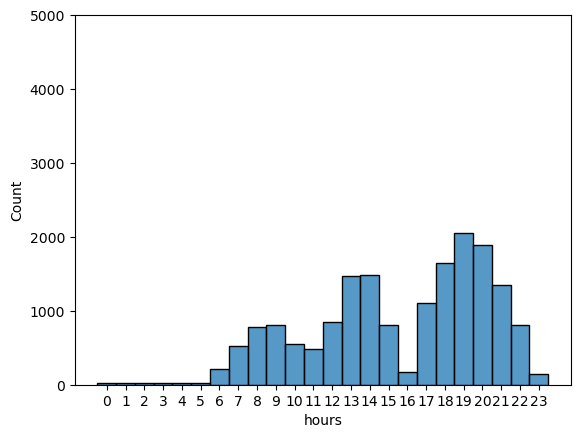

In [10]:
# проверка получившегося распределения часов

time_hours, title = offline_24h_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 5000);

<br>

### 2. Круглосуточные оффлайн категории - фрод.
- фрод транзакции в круглосуточных оффлайн категориях

In [11]:
def offline_24h_fraud_time_dist():
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. 24h. Fraud"
    
    # равномерная активность с 8 до 23
    day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)
    
    # равномерная сниженная активность с 0 до 8
    night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)
    
    # соединяем все созданные массивы в один и делаем серией
    time_hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")

    return time_hours, title

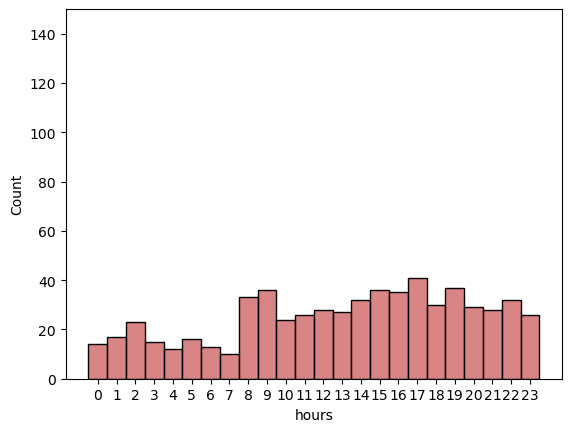

In [12]:
time_hours, title = offline_24h_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 150);

<br><br>

### 3. Онлайн категории, НЕ фрод `online_legit_time_dist`
- Легитимные транзакции. Онлайн покупки. Круглые сутки.
- Равномерно низкая активность ночью и рано утром: с 23:00 до 08:00
- Равномерно низкая активность с 08:00 до 12:00, но чуть выше чем ночью
- небольшой пик в обед: с 12:00 до 16:00
- Пик Вечером после 17:00. между 17 и 22 включительно

In [14]:
def online_legit_time_dist():
    
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Online. Legit"
    
    # Первый слой. равномерно с утра до вечера. с 8:00 до 16:59
    day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)
    
    # небольшой пик обед в районе 13. Обрезанный по 12 и 17 часам
    mean_noon = 14 * 60
    std_noon= 75
    noon_start = 12 * 60
    noon_end = 16.5 * 60
    
    # пик обед. Распределение
    dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(400).astype(int)
    
    # Вечерний пик. От 17 до 23 часов.
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 23.3 * 60
    
    # пик вечером. Распределение
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(2000).astype(int)
    
    # ночная равномерная низкая активность с 0 до 7:59 утра
    night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  
    
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

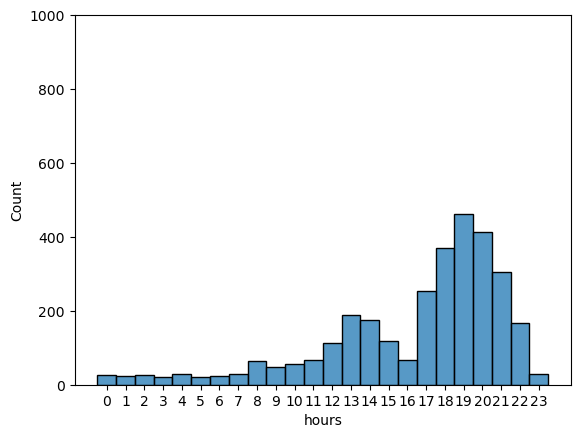

In [15]:
# проверка результата

time_hours, title = online_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.unique())
p.set_ylim(0, 1000);

<br>

### 4. Онлайн фрод
- Равномерно с раннего утра до вечера
- активность вечером-ночью с пиком в районе 00:00

In [16]:
def online_fraud_time_dist():
    # Время в минутах с начала суток. В данном случае нужно для ограничения распределения в рамках 24 часов.
    start, end = 0, 1439  # 00:00 до 23:59

    # название паттерна. Пригодится если нужно построить график распределения
    title = "Online. Fraud"
    
    # Ночной пик после 00:00
    mean = 1 # 1-я минута суток
    std = 120
    
    # распределение ночного пика с максимумом примерно в первом часу суток: 00:00-00:59.
    # Обрезка распределения слева по 00:00
    dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
    minutes = dist.rvs(2000).astype(int)
    
    # Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
    mean_evn = 23.9*60
    std_evn = 120
    evn_end = 23.9*60
    
    dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(2000).astype(int)
    
    # добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
    mid_start = 4 * 60
    mid_end = 20.9 * 60
    midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)
    
    # соединяем все три массива
    total_minutes = np.concatenate((minutes, midday_add, minutes_evn)) # 
    
    times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

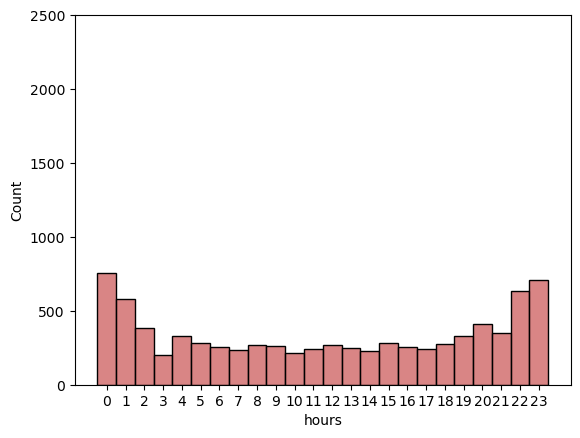

In [17]:
time_hours, title = online_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,2500);

<br>

### 5. Дневной оффлайн, легитимные транзакции.
- Время с 8:00 до 22:00. С пиками в обед (небольшой) и вечером (основной)

In [18]:
def offline_day_legit_time_dist():
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. Day-only. Legit"
    
    # равномерное распределение с 8:00 до 17:00
    day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)
    
    # слабый пик обед в районе 13. Интервал с 12 до 17:00
    mean_noon = 14 * 60
    std_noon= 75
    noon_start = 12 * 60
    noon_end = 16.5 * 60
    
    # пик обед
    dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
    minutes_noon = dist_noon.rvs(1000).astype(int)
    
    # Вечерний пик. С 17:00 до 22:00
    mean_evn = 19.7 * 60
    std_evn = 120
    evn_start = 17 * 60
    evn_end = 21.9 * 60
    
    # пик вечером
    dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
    minutes_evn = dist_evn.rvs(9000).astype(int)
    
    # соединяем все созданные массивы в один
    minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #
    
    # переводим значения массива в тип pd.Timedelta.
    # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
    # берем hours оттуда
    times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
    time_hours = times.hours

    return time_hours, title

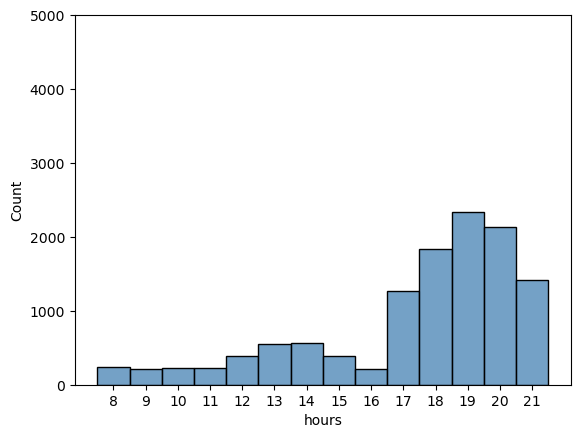

In [19]:
time_hours, title = offline_day_legit_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="steelblue")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,5000);

<br>

### 6. Дневной оффлайн. Фрод
- равномерно с 08:00 до 22:00

In [20]:
def offline_day_fraud_time_dist():
    # название паттерна. Пригодится если нужно построить график распределения
    title = "Offline. Day-only. Fraud"

    # равномерная активность с 8:00 до 22:00
    day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)
    
    # переведем массив в серию
    time_hours = pd.Series(day_time, name="hours")

    return time_hours, title

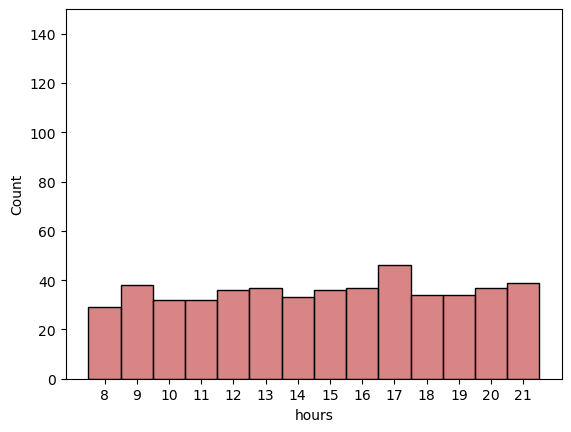

In [21]:
time_hours, title = offline_day_fraud_time_dist()

p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 150);

<br><br>

## **Оркестрирующие функции генерации паттернов времени**

<br>

## 1. Функция генерации весов для часов в периоде времени `gen_weights_for_time` - Созданная из подфункций <br>
- на основании созданных функций распределений времени для соответсвующих временных паттернов, выдает веса (доли) для каждого часа в распределении, которые будут в использоваться в рандомизации времени генерируемой транзакции

In [22]:
def gen_weights_for_time(is_fraud=False, round_clock=False, online=False):
    """
    возвращает датафрейм с часами от 0 до 23 и их весами,
    название паттерна в виде строки и цвет для возможного графика - в зависимости от фрод не фрод
    
    is_fraud - True или False. По умолчанию False
    round_clock - Круглосуточная категория или нет. True или False. По умолчанию False
    online - None, True или False. По умолчанию False
    """
    #  Далее в зависимости от условий генерация распределения времени для транзакций

    # 1. Категория - круглосуточные, оффлайн, НЕ фрод 
    if not is_fraud and round_clock and not online:
        time_hours, title = offline_24h_legit_time_dist()
        
    # 2. Оффлайн фрод. круглосуточные категории
    elif is_fraud and round_clock and not online:
        time_hours, title = offline_24h_fraud_time_dist()

    # 3. НЕ фрод. Онлайн покупки
    elif not is_fraud and round_clock and online:
        time_hours, title = online_legit_time_dist()
        
    # 4. онлайн фрод
    elif is_fraud and round_clock and online:
        time_hours, title = online_fraud_time_dist()

    # 5. Не круглосуточный. Не фрод. Оффлайн
    elif not is_fraud and not round_clock and not online:
        time_hours, title = offline_day_legit_time_dist()

    # 6. Фрод. Не круглосуточный. Оффлайн. 
    elif is_fraud and not round_clock and not online:
        time_hours, title = offline_day_fraud_time_dist()
        
    # посчитаем долю каждого часа. Это и будут веса 
    # т.е. вероятность транзакций в этот час для выбранного временного паттерна
    # переведем индекс в колонку т.к. в индексе у нас часы
    hour_weights = time_hours.value_counts(normalize=True).sort_index().reset_index()

    # если период не круглосуточный. То добавить колонку остальных часов со значениями равными 0, для построения графиков со шкалой от 0 до 23
    if not round_clock:
        all_hours = pd.DataFrame({"hours":np.arange(0,24, step=1)}).astype(int)
        hour_weights = all_hours.merge(hour_weights, how="left", on="hours").fillna(0)
        
    # цвет для графика.
    if not is_fraud:
        color = "steelblue"
    elif is_fraud:
        color = "indianred"
        
    return hour_weights, title, color

<br>

## 2. Функция генерации весов для всех паттернов времени и сбора их в словарь
- содержит в себе функцию `gen_weights_for_time()`
- нужна для генерации всех паттернов один раз, чтобы дальше не вызывать функцию генерации каждого паттерна каждый раз для транзакции либо по отдельности записывать в переменные

In [23]:
def get_all_time_patterns(pattern_args):
    """
    pattern_args - словарь с названием паттерна в ключе и словарем из аргументов для функции gen_weights_for_time,
                   соответствующим паттерну.
    """

    time_weights = defaultdict(dict)
    
    for key in pattern_args.keys():
        weights, title, color = gen_weights_for_time(**pattern_args[key])
        time_weights[key]["weights"] = weights
        time_weights[key]["title"] = title
        time_weights[key]["color"] = color

    return time_weights

<br>

## 3. Тест функции `gen_weights_for_time()`

In [24]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

### А. Графики каждого из распределений весов времени
- запустим функцию и построим график каждого из распределений

**Функция построения одиночного графика распределения**

In [25]:
def plot_time_weights(weights, title, color, ax):
    sns.barplot(x=weights.hours, y=weights.proportion, color=color, ax=ax)
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(0, 0.4)
    ax.grid(axis="y")
    ax.set_title(title)

In [28]:
time_weights_test = get_all_time_patterns(time_weight_args)

**Функция построения нескольких графиков time_weights в две колонки**

In [26]:
def plot_all_patterns(time_weights):
    """
    Строит графики всех распределений из time_weights
    time_weights - словарь с ключами - названиями паттернов и
                   под каждым ключом еще словарь с весами для паттерна,
                   названием для графика и цветом графика.
                   Его можно сгенерировать функцией get_all_time_patterns
    """
    dict_len = len(time_weights)
    rows_number = math.ceil(dict_len / 2)
    
    rows_list = []
    one_row = []
      
    for index, key in enumerate(time_weights.keys(), start=1):
        one_row.append(key)
        if len(one_row) == 2 or index == dict_len:
            rows_list.append(one_row.copy())
            one_row = []
    
    fig, axes = plt.subplots(nrows=rows_number, ncols=2, figsize=(10, rows_number*3))
    
    for sub_axes, keys in zip(axes, rows_list):
        for ax, key in zip(sub_axes, keys):
            weights = time_weights[key]["weights"]
            title = time_weights[key]["title"]
            color = time_weights[key]["color"]
            # строим график на его оси
            plot_time_weights(weights, title, color, ax)
    
    plt.tight_layout()
    plt.show()

#### **Построим графики для всех распределений**

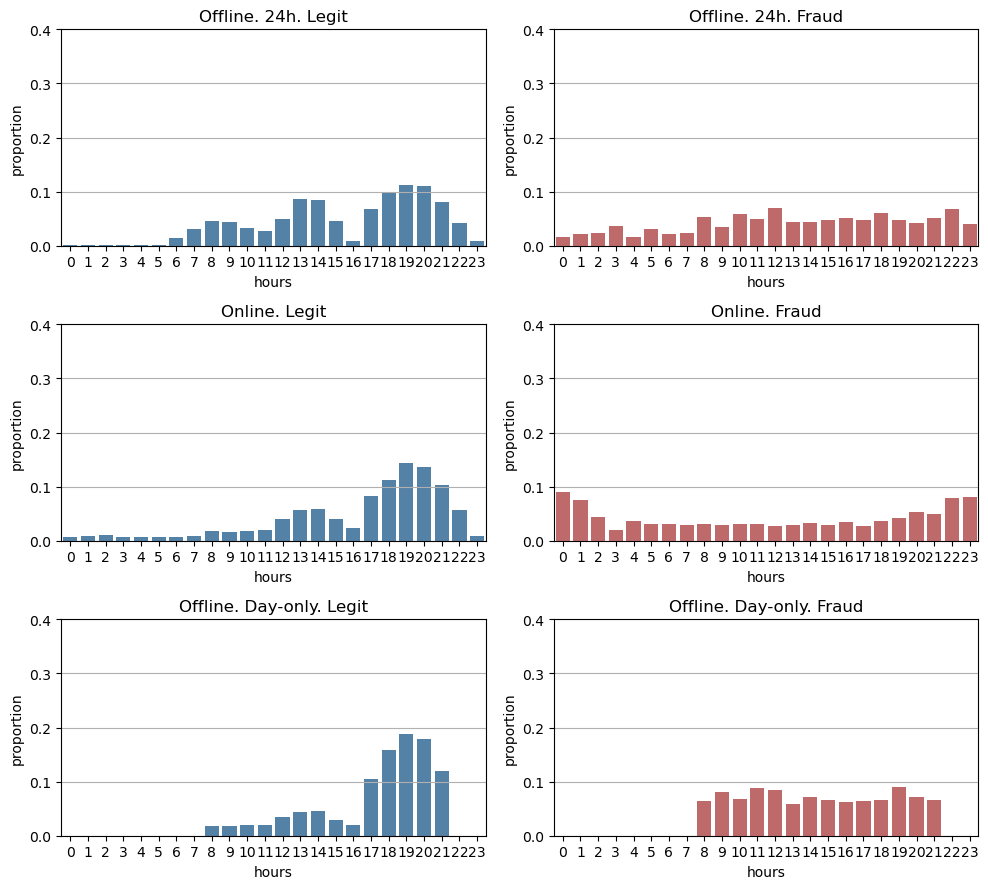

In [29]:


plot_all_patterns(time_weights_test)

### Б. Проверка функции `gen_weights_for_time` на генерацию пустых значений
Запустим функцию 100 раз для каждого типа распределения и проверим были ли случаи когда для какого-то часа не создался вес.
Будет посчитано количество случаев когда создалось распределение с весами не для всех часов, которые указаны в периоде для распределения

In [30]:
# словарь для подсчета распределений в которых были пустые значения
empt = defaultdict(int)

# итерирование через варианты распределений
for preset in time_weight_args.keys():
    i = 0
    round_clock =  time_weight_args[preset]["round_clock"]

    # создать каждое распределение 100 раз
    while i < 100:
        weights, _, _ = gen_weights_for_time(**time_weight_args[preset])
        
        # если круглосуточное распределение и меньше 24 записей
        if round_clock and weights.shape[0] < 24:
            empt[preset] += 1
            
        # если чисто дневное распределение и меньше 14 записей (22 - 8)
        elif not round_clock and weights[weights.proportion != 0].shape[0] < (22 - 8):
            empt[preset] += 1
        
        i += 1

# если словарь не пуст, то ошибка
if empt:
    raise ValueError(f"Some time distributions may generate 0 values. {empt}")
else:
    print("No empty values generated in distributions")

No empty values generated in distributions


<br><br>

# **Другие базовые функции для генерации времени**

<br>

## 1. Функции для генерации диапазона timestamp-ов

**А. Функция перевода pd.Series с datetime64 в unix time в секундах**

In [42]:
def datetime_series_to_unix(series):
    """
    Функция перевода pd.Series с datetime64 в unix time в секундах
    ----------------------
    series - pd.Series с типом datetime64
    """
    unix_time_series = (series - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return unix_time_series

**Б. Функция создания датафрейма с диапазоном timestamp-ов**

In [43]:
def create_timestamps_range_df(start, end, format="%Y-%m-%d", freq="min"):
    """
    функция создания датафрейма с диапазоном timestamp-ов.
    Возвращает pd.DataFrame | timestamp | hour | unix_time
    -----------------------------------------------------
    start - str. начало диапазона. Дата или дата и время формата указанного в format. По умолчанию %Y-%m-%d
    end - str. конец диапазона. Дата или дата и время формата указанного в format. По умолчанию %Y-%m-%d
    format - str. Строка формата stftime. Формат передаваемых start и end. 
    freq - str. частота генерации timestamp-ов. Минуты, секунды, дни и т.д. 'min', 's', 'D' etc.
    """
    timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime(start, format=format), \
                                                  pd.to_datetime(end, format=format), freq=freq), name="timestamp"))
    timestamps["hour"] = timestamps.timestamp.dt.hour
    timestamps["unix_time"] = datetime_series_to_unix(timestamps.timestamp)

    return timestamps

**В. Функция перевода pd.Timestamp в unix время**

In [44]:
def pd_timestamp_to_unix(timestamp):
    """
    Переводит pandas timestamp в unix время
    timestamp - чистый pandas timestamp. Без индексов. Не серия, не датафрейм.
    """
    unix_time = (timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return unix_time

<br>

## 2. Функция для генерации случайного времени транзакций согласно весам `sample_time_for_trans`

In [46]:
def sample_time_for_trans(timestamps, time_weights):
    """
    Семплирует время из данных timestamps согласно переданным весам
    ------------------------------
    timestamps - pd.DataFrame. С колонками: | timestamp | unix_time | hour |  - pd.Timestamp, int, int.
    time_weights - pd.DataFrame. С колонками: | hours | proportion | - int, float.
    ------------------------------
    Возвращает pd.Timestamp и int unix время в секундах
    """
    # семплируем час из весов времени, указав веса для семплирования
    txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
    
    # фильтруем основной датафрейм с диапазоном таймстемпов по этому часу
    timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
    
    # из отфильтрованного датафрейма таймстемпов семплируем один таймстемп с равной вероятностью
    txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
    txn_unix = pd_timestamp_to_unix(txn_time)

    return txn_time, txn_unix